# Class Histogram Per Position Analysis - MNIST Dataset

In this experiment, we try the following modifications in the class histogram per position analysis using a small mnist model:

- Position Selectivity: Entropy/Perplexity/Average difference for every pair of bins. Testing using both HistVector and SelecVector.
    - Class Selectivity: Average distance of class ci to all others.
- Kernel Selectivity: Simple metrics are max, mean and median of the Position Selectivity. Another approach is to count the number of kernels each class is the predominant one. The selectivity could be:
    - The number of kernels the class with more kernels has / all kernels.
    - The average difference between the number of kernels each pair of class has.
    - The predominance may be multiplied by the position selectivity.
- Visualize before clustering in order to check the best technique. Probably one without fixed K.


- One histogram per class mapping the distribution of the activation (absolute value).
- Produce an Entropy/Perplexity Vector to represent the position.
- Position Selectivity is the average difference between the distributions/histograms.
- Kernel Selectivity: Simple metrics are max, mean and median of the Position Selectivity. Another approach is to count the number of kernels each class has the better entropy/perplexity. The selectivity could be:
    - The number of kernels the class with more kernels has / all kernels.
    - The average difference between the number of kernels each pair of class has.
    - The predominance may be multiplied by the position selectivity.
- When select the position, show all C histograms.


- Try Mean Activation Vector also for comparison.


- Display a histogram counting the amount of training elements activating for each range of neurons. Update at each removal.

## Dataset

MNIST dataset composed of handwritten digits from 0 to 9 (10 classes).

In [1]:
import numpy as np
import importlib
import random
import math
import json

import auxiliar_functions as af

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.colorbar import ColorbarBase

from keras.datasets import cifar10, mnist
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.utils import np_utils
from keras.optimizers import SGD, Adadelta
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import mode

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

input_shape = x_train.shape[1:]
num_classes = y_train.shape[1]

labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## Model

We first use a very simple model of 2 conv layers (16 kernels) and 1 dense layer (16 units).

In [3]:
model = load_model('models/mnist_16c_16c_16d.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                50192     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 52,842
Trainable params: 52,842
Non-trainable params: 0
_________________________________________________________________


In [4]:
p_labels = np.argmax(model.predict(x_train), axis=1) # Predicted labels for training set.
t_labels = np.argmax(y_train, axis=1) # True labels for training set.

scores = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 96.96%


## 1st Layer Analysis

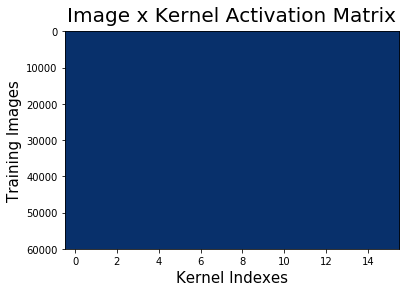

0

In [5]:
m0 = af.activation_matrix_conv2d(model, 0, x_train, t_labels, p_labels, num_classes)
af.plot_activation_matrix(m0)

In [6]:
h0, s0 = af.class_histogram_conv2d_v3(model, 0, x_train, t_labels, p_labels, num_classes)
h0.shape, s0.shape

((16, 28, 28, 10), (16, 28, 28, 10))

In the image below, each matrix $M_{i,j}$ corresponds to the bin sizes produced by the $i$-th neuron for the $j$-th class. Each matrix position ${k,l}$ is the bin size produced in the position/pixel ${k,l}$ of the $i$-th neuron for the $j$-th class

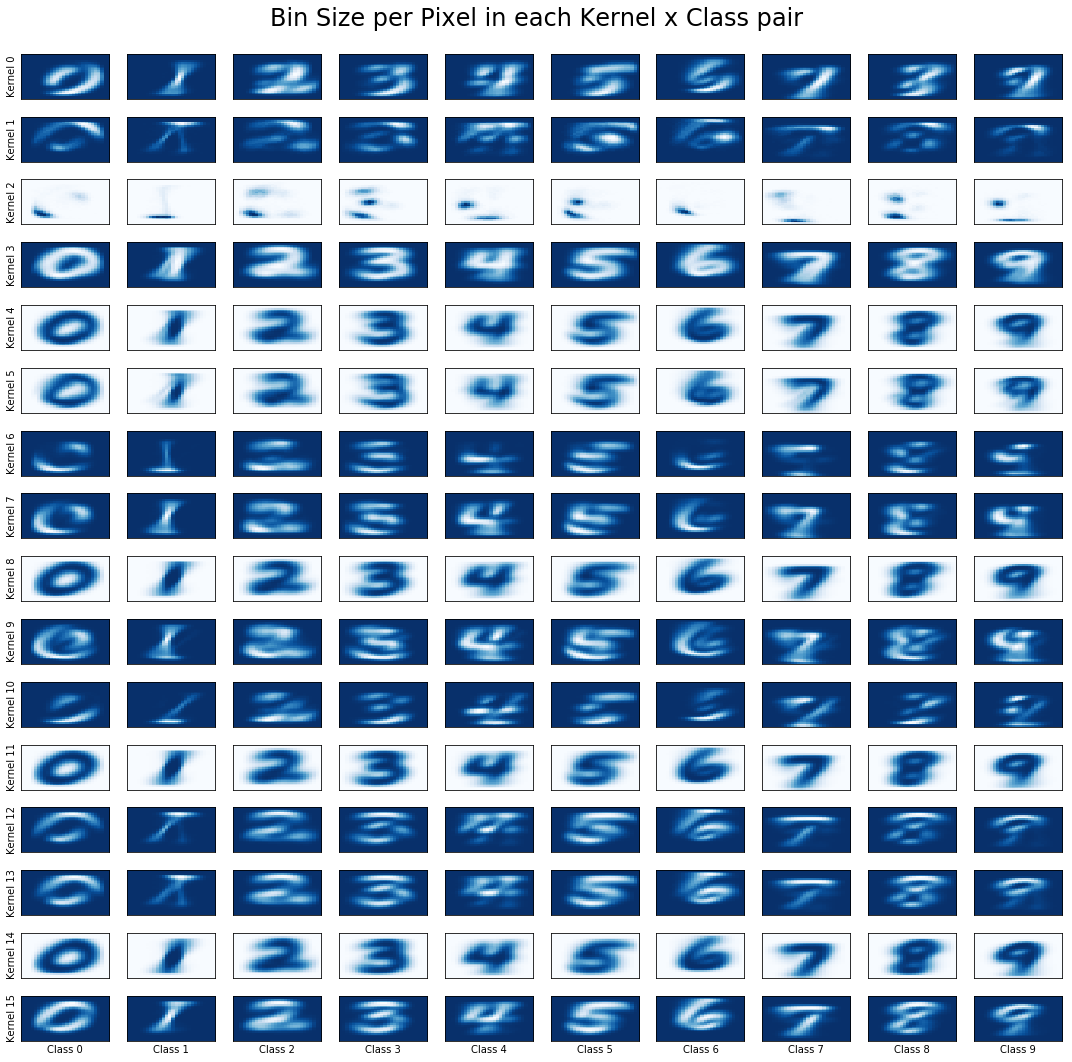

In [7]:
n_rows = h0.shape[0]
n_cols = h0.shape[3]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))

f.suptitle('Bin Size per Pixel in each Kernel x Class pair', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].imshow(h0[i, :, :, j], aspect='auto', cmap=cm.Blues)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(i))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel('Class ' + str(j))

f.tight_layout(rect=[0, 0, 1, 0.95])

We can identify four types of kernels in the first convolutional layer of the model:
* Kernels activating more in the 'digit areas': 4, 5, 8, 11, 14
* Kernels activating more in the 'background areas': 0, 3, 7, 9, 12, 13, 15
* Kernels activating more in the 'digit areas' but not clearly displaying the digits: 2
* Kernels activating more in the 'background areas' but not clearly displaying the digits: 1, 6 10

Some of the 'background kernels' seems to be focusing on borders as well.

In [8]:
h0 = af.merge_pixels_dim(h0)
s0 = af.merge_pixels_dim(s0)
h0.shape, s0.shape

((16, 784, 10), (16, 784, 10))

In [10]:
dh0 = af.position_selectivity(h0)
ds0 = af.position_selectivity(s0)

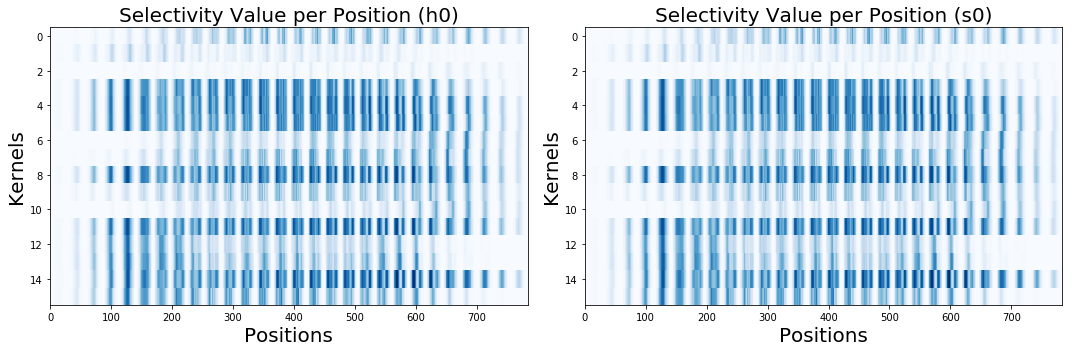

In [11]:
f, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 5))

ax0.imshow(dh0, aspect='auto', cmap=cm.Blues)
ax1.imshow(ds0, aspect='auto', cmap=cm.Blues)

ax0.set_ylabel('Kernels', fontsize=20)
ax0.set_xlabel('Positions', fontsize=20)
ax0.set_title('Selectivity Value per Position (h0)', fontsize=20)

ax1.set_ylabel('Kernels', fontsize=20)
ax1.set_xlabel('Positions', fontsize=20)
ax1.set_title('Selectivity Value per Position (s0)', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

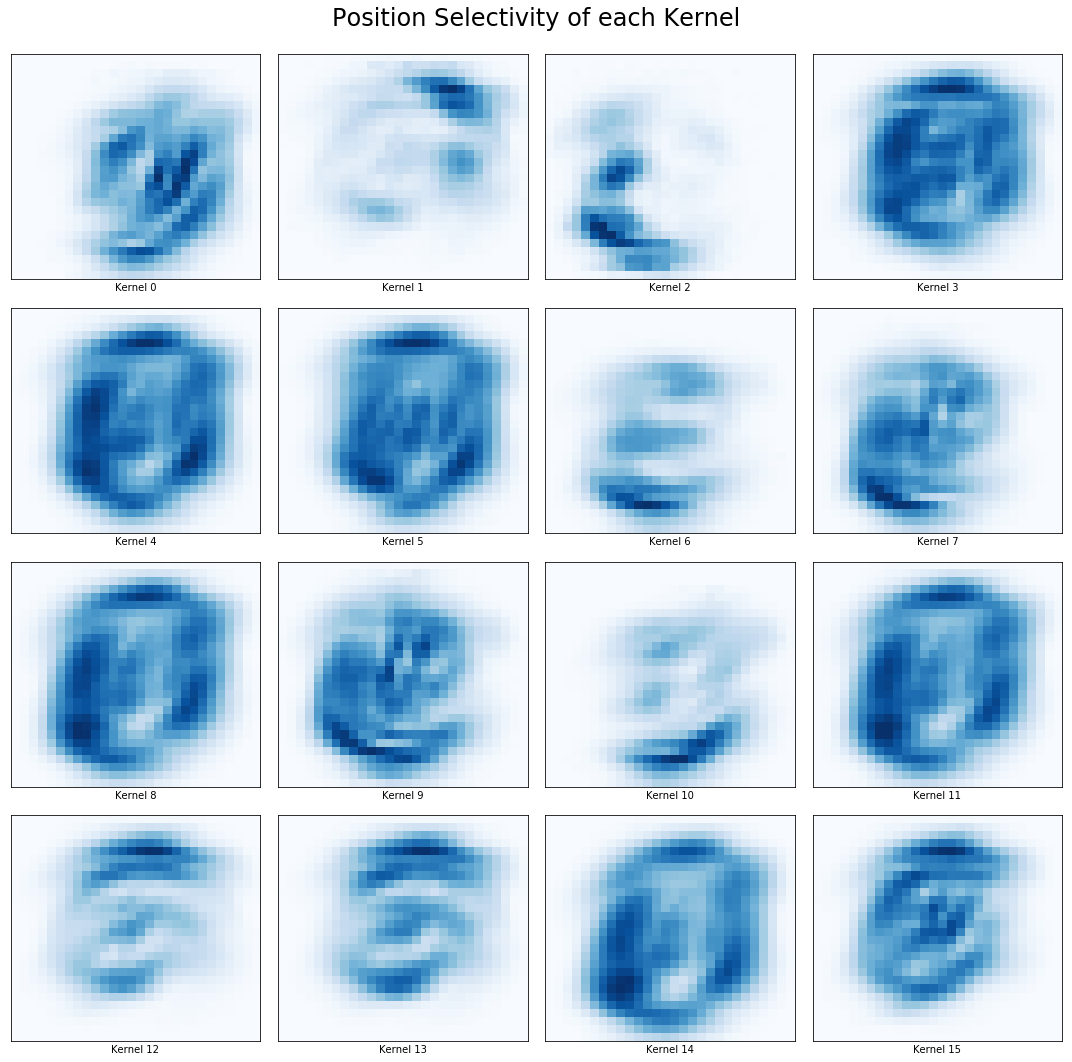

In [12]:
n_rows = int(math.sqrt(dh0.shape[0]))
n_cols = int(math.sqrt(dh0.shape[0]))

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))

f.suptitle('Position Selectivity of each Kernel', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        k = n_rows*i + j
        
        axs[i, j].imshow(dh0[k, :].reshape((28, 28)), aspect='auto', cmap=cm.Blues)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xlabel('Kernel ' + str(k))

f.tight_layout(rect=[0, 0, 1, 0.95])

In [13]:
dch0 = af.position_class_selectivity(h0)
dcs0 = af.position_class_selectivity(s0)

dch0.shape, dcs0.shape

((16, 784, 10), (16, 784, 10))

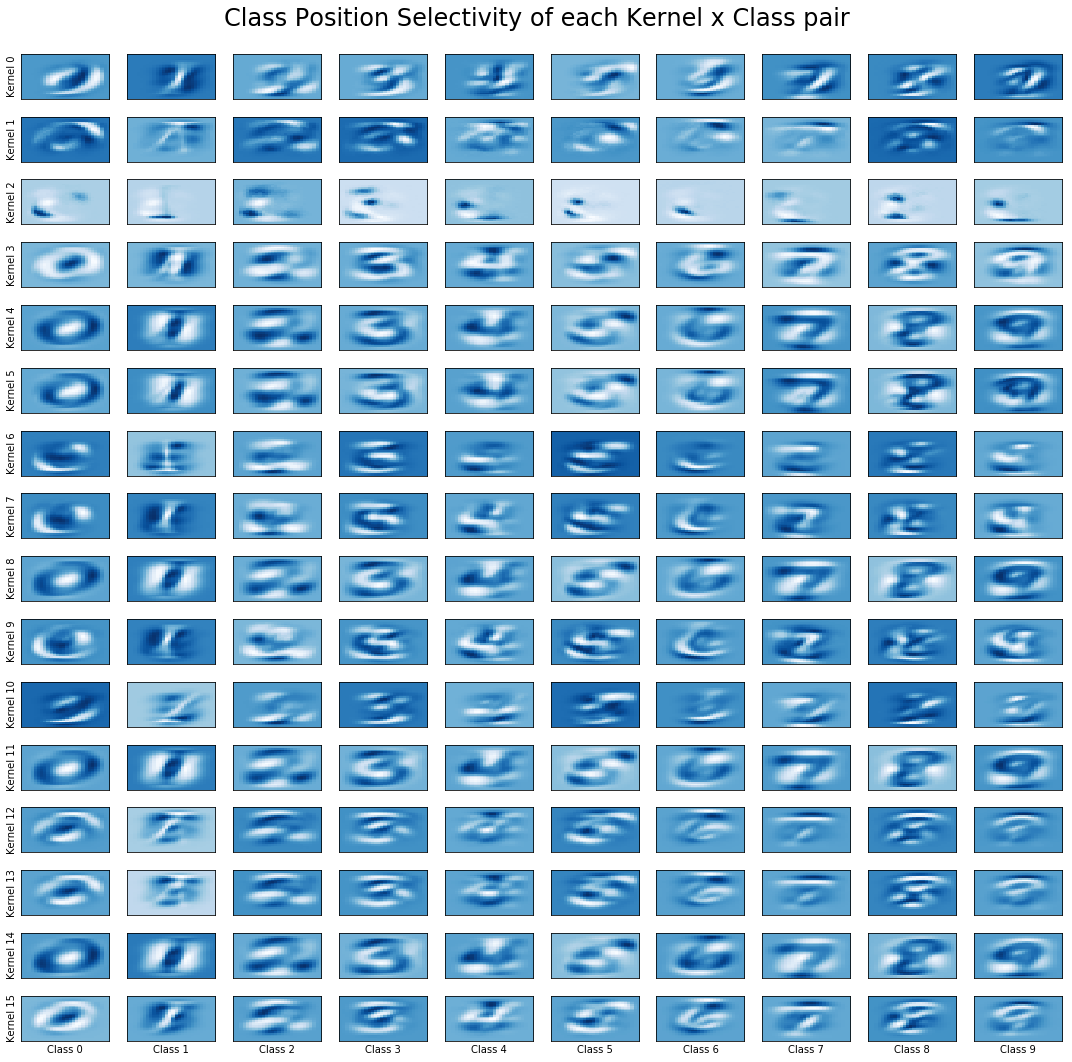

In [14]:
n_rows = dch0.shape[0]
n_cols = dch0.shape[2]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))

f.suptitle('Class Position Selectivity of each Kernel x Class pair', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].imshow(dch0[i, :, j].reshape((28, 28)), aspect='auto', cmap=cm.Blues)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(i))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel('Class ' + str(j))

f.tight_layout(rect=[0, 0, 1, 0.95])

In [15]:
remains = np.array([0, 3, 4, 7, 13])
n_model = af.reduce_model_units(model, 0, remains)
n_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 5)         50        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        736       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                50192     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 51,148
Trainable params: 51,148
Non-trainable params: 0
_________________________________________________________________


In [16]:
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 91.37%


In [17]:
remains = np.array([4, 5, 8, 11, 14])
n_model = af.reduce_model_units(model, 0, remains)
n_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 5)         50        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        736       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                50192     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                170       
Total params: 51,148
Trainable params: 51,148
Non-trainable params: 0
_________________________________________________________________


In [18]:
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 78.91%


In [19]:
remains = np.array([0, 10, 12, 13, 15])
n_model = af.reduce_model_units(model, 0, remains)
n_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 5)         50        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        736       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                50192     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                170       
Total params: 51,148
Trainable params: 51,148
Non-trainable params: 0
_________________________________________________________________


In [20]:
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 61.20%


In [21]:
avg_score = 0.0
t = 20

for _ in range(t):
    remains = np.array(random.sample(range(16), 5))
    n_model = af.reduce_model_units(model, 0, remains)
    
    scores = n_model.evaluate(x_test, y_test, verbose=2)
    avg_score += scores[1]*100 / t
    
print("Average Accuracy with Random Dropping: %.2f%%" % avg_score)

Average Accuracy with Random Dropping: 78.16%


Back to our chosen kernels...

In [22]:
remains = np.array([0, 3, 4, 7, 13])
n_model = af.reduce_model_units(model, 0, remains)

n_model.layers[0].trainable = False
n_model.compile(loss=categorical_crossentropy, optimizer=Adadelta(), metrics=['accuracy'])

n_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 28, 28, 5)         50        
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 28, 28, 16)        736       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 16)                50192     
_________________________________________________________________
dense_48 (Dense)             (None, 10)                170       
Total params: 51,148
Trainable params: 51,098
Non-trainable params: 50
_________________________________________________________________


In [23]:
h = n_model.fit(x_train, y_train, batch_size=128, epochs=1, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 36s 608us/step - loss: 0.1282 - acc: 0.9654 - val_loss: 0.0814 - val_acc: 0.9745


In [24]:
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 97.45%


Testing kernel selectivity metrics...

In [25]:
importlib.reload(af);
ks_max = af.kernel_selectivitity(h0, dh0, 'max')
ks_mean = af.kernel_selectivitity(h0, dh0, 'mean')
ks_median = af.kernel_selectivitity(h0, dh0, 'median')
ks_pond = af.kernel_selectivitity(h0, dh0, 'pond')

ks_max.shape, ks_mean.shape, ks_median.shape

((16,), (16,), (16,))

In [26]:
np.argsort(ks_max)

array([ 2,  1,  9, 10,  0,  6,  7, 15, 12, 13,  3,  5,  4,  8, 11, 14])

In [27]:
np.argsort(ks_mean)

array([ 2,  1, 10,  6,  0, 12,  9,  7, 13, 15,  3,  5,  4, 11,  8, 14])

In [28]:
np.argsort(ks_median)

array([ 2,  1, 10,  6,  0,  7, 12, 15, 13,  9,  3,  5,  4, 11,  8, 14])

In [29]:
np.argsort(ks_pond) # equal to ks_mean in this case

array([ 2,  1, 10,  6,  0, 12,  9,  7, 13, 15,  3,  5,  4, 11,  8, 14])

In [30]:
remains0 = np.array([0, 3, 4, 7, 13])
remains1 = np.array([0, 3, 7, 13, 14])
remains2 = np.array([0, 3, 7, 14, 15])
remains3 = np.array([0, 3, 9, 13, 14])

In [31]:
n_model = af.reduce_model_units(model, 0, remains0)
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 91.37%


In [32]:
n_model = af.reduce_model_units(model, 0, remains1)
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 92.56%


In [33]:
n_model = af.reduce_model_units(model, 0, remains2)
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 94.40%


In [34]:
n_model = af.reduce_model_units(model, 0, remains3)
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 83.12%


- Clustering and Projection.

In [129]:
h0k0 = h0[2, :, :] # First kernel histograms
h0k0.shape

(784, 10)

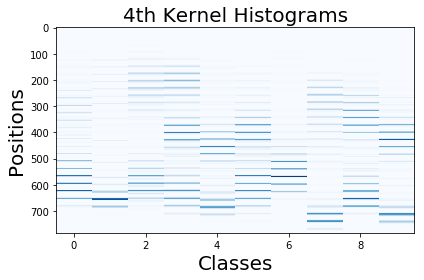

In [130]:
f, ax = plt.subplots()

ax.imshow(h0k0, aspect='auto', cmap=cm.Blues)

ax.set_ylabel('Positions', fontsize=20)
ax.set_xlabel('Classes', fontsize=20)
ax.set_title('4th Kernel Histograms', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

In [131]:
p0k0, div = af.project_histogram(h0k0, p=50, e=12.0, l=200.0)
p0k0.shape, div

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 784 samples in 0.001s...
[t-SNE] Computed neighbors for 784 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 784 / 784
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.584652
[t-SNE] Error after 1000 iterations: 0.585194


((784, 2), 0.5851941704750061)

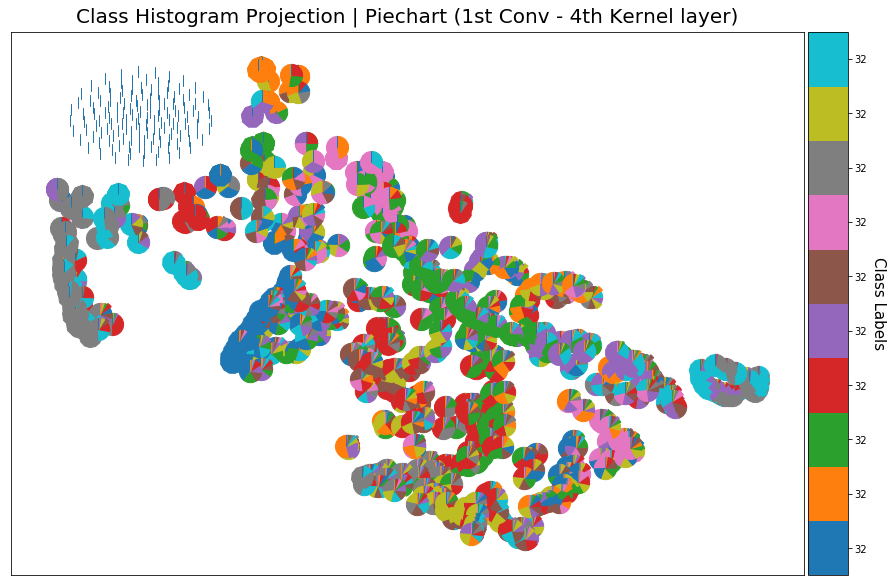

In [132]:
af.plot_projection_piechart(p0k0, h0k0, 10, labels, '1st Conv - 4th Kernel', -1, 500)

In [142]:
clustering = AffinityPropagation(damping=0.99).fit(h0k0)
# clustering = MeanShift(bandwidth=0.5).fit(h0k0)
# clustering = DBSCAN(eps=0.3).fit(h0k0)

l0k0 = clustering.labels_
l0k0.shape, np.max(l0k0)

((784,), 79)

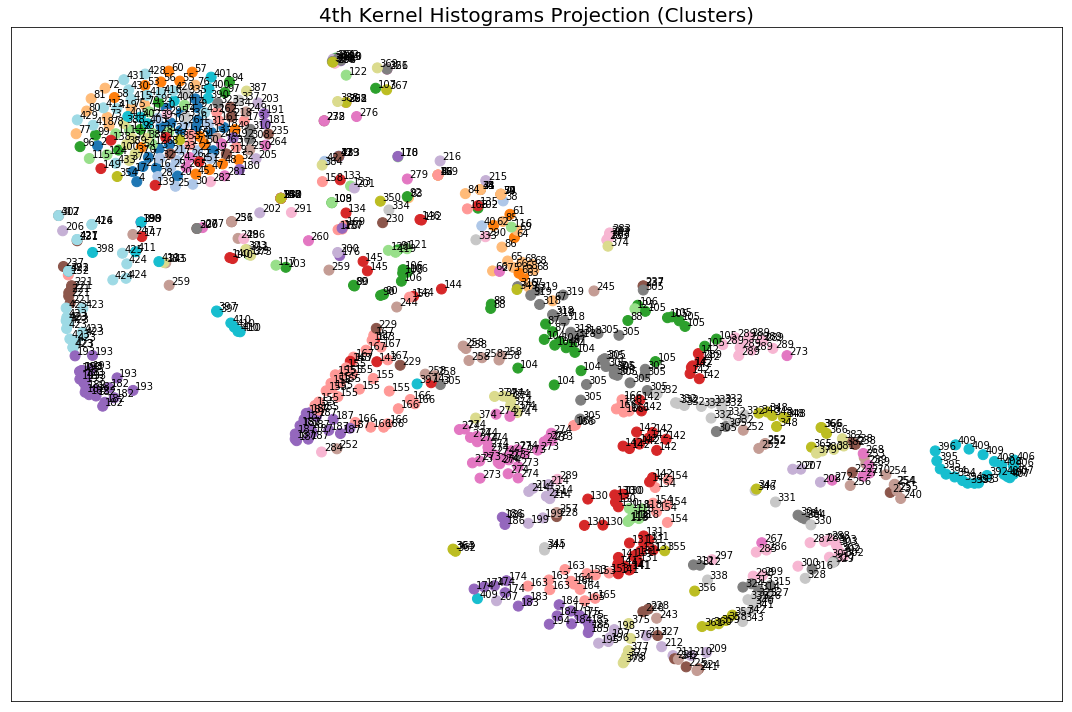

In [134]:
f, ax = plt.subplots(figsize=(15, 10))

im = ax.scatter(p0k0[:, 0], p0k0[:, 1], c=l0k0, cmap=cm.tab20, s=100)

for i, p in enumerate(p0k0):
    ax.annotate(str(l0k0[i]), (p[0] + .1, p[1] + .1))

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('4th Kernel Histograms Projection (Clusters)', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

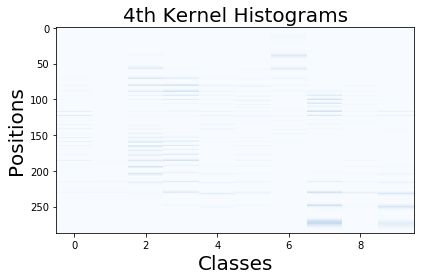

In [124]:
f, ax = plt.subplots()

ax.imshow(h0k0[l0k0 == 33], aspect='auto', cmap=cm.Blues, vmin=0.0, vmax=1.0)

ax.set_ylabel('Positions', fontsize=20)
ax.set_xlabel('Classes', fontsize=20)
ax.set_title('4th Kernel Histograms', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

Testing automatic removal...

In [164]:
h0k0 = h0[0, :, :] # First kernel histograms
h0k0.shape

(784, 10)

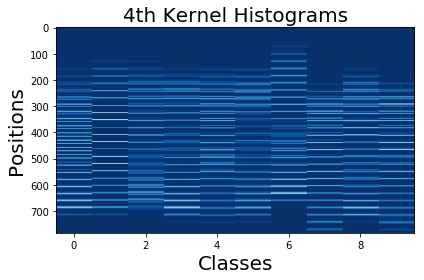

In [166]:
f, ax = plt.subplots()

ax.imshow(h0k0[np.max(h0k0, axis=1) > 0.2], aspect='auto', cmap=cm.Blues, vmin=0.0, vmax=1.0)

ax.set_ylabel('Positions', fontsize=20)
ax.set_xlabel('Classes', fontsize=20)
ax.set_title('4th Kernel Histograms', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

Applying the clustering technique to the whole layer...

In [179]:
c0 = []
i0 = []

n = 0
for k in range(h0.shape[0]):
    h0k0 = h0[k, :, :]
    h0k0 = h0k0[np.max(h0k0, axis=1) > 0.1]
    
    clustering = AffinityPropagation(damping=0.75).fit(h0k0)
    labels = clustering.labels_
    centers = clustering.cluster_centers_

    c0.append(centers)
    i0.append([k for _ in range(centers.shape[0])])
    
    n += centers.shape[0]

h0.shape, n

((16, 784, 10), 701)

In [190]:
c1 = c0[0]
i1 = i0[0]
for i in range(1, len(c0)):
    c1 = np.append(c1, c0[i], axis=0)
    i1 = np.append(i1, i0[i])

len(c0), c0[0].shape, c1.shape, i1.shape

(16, (52, 10), (701, 10), (701,))

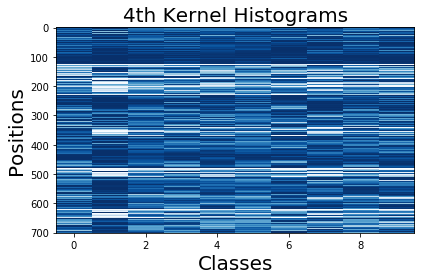

In [191]:
f, ax = plt.subplots()

ax.imshow(c1, aspect='auto', cmap=cm.Blues)

ax.set_ylabel('Positions', fontsize=20)
ax.set_xlabel('Classes', fontsize=20)
ax.set_title('4th Kernel Histograms', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

In [192]:
p0c1, div = af.project_histogram(c1, p=50, e=12.0, l=200.0)
p0c1.shape, div

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 701 samples in 0.006s...
[t-SNE] Computed neighbors for 701 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 701 / 701
[t-SNE] Mean sigma: 0.159091
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.773987
[t-SNE] Error after 1000 iterations: 0.738549


((701, 2), 0.738548994064331)

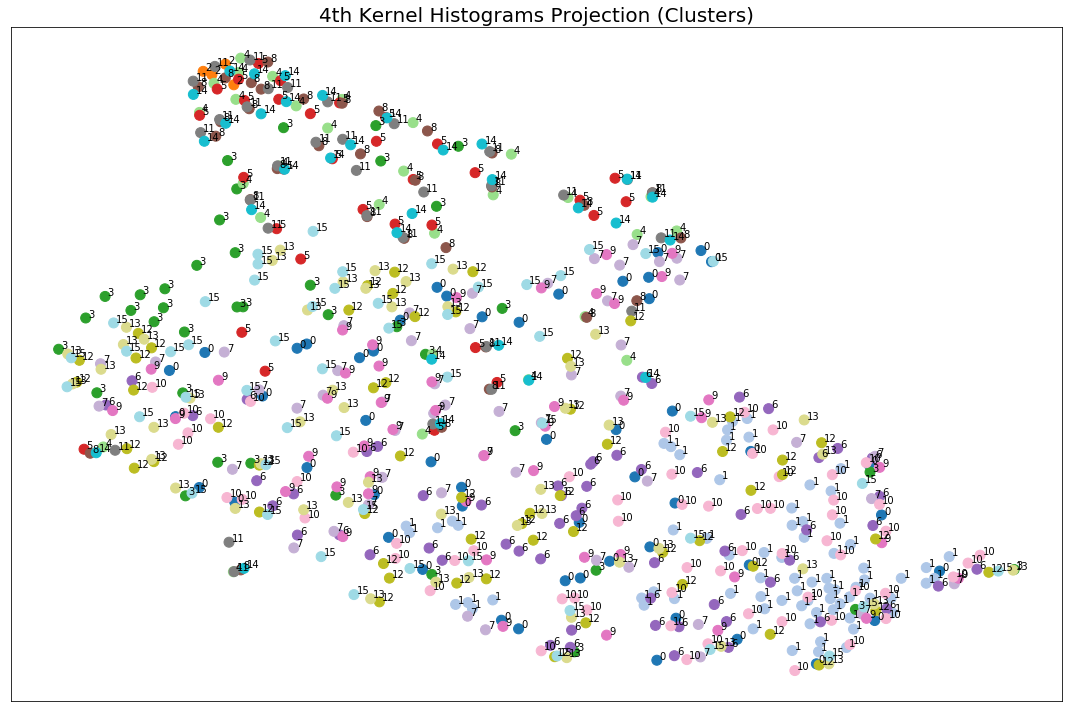

In [193]:
f, ax = plt.subplots(figsize=(15, 10))

im = ax.scatter(p0c1[:, 0], p0c1[:, 1], c=i1, cmap=cm.tab20, s=100)

for i, p in enumerate(p0c1):
    ax.annotate(str(i1[i]), (p[0] + .1, p[1] + .1))

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('4th Kernel Histograms Projection (Clusters)', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

Not sure if it makes sense to compare similarities between positions of different indexes

What could be an alternative...?

Design a Difference Matrix DM measuring the difference between each kernel. The matrix DF has KxK cells. Each cell $i,j$ measures the difference between kernel i and kernel j. The difference between two kernels is the average difference between each bin in each position of both kernels.

In [253]:
dm = np.zeros((h0.shape[0], h0.shape[0]))

for k1 in range(h0.shape[0]):
    for k2 in range(h0.shape[0]):
        dm[k1, k2] = np.sum(np.abs(h0[k1, :, :] - h0[k2, :, :])) # Sum and mean bring similar results.

dm.shape

(16, 16)

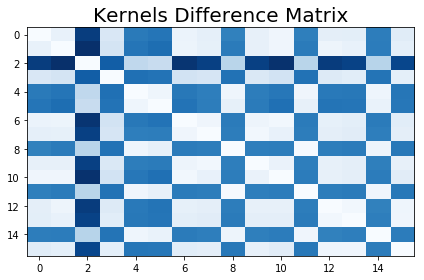

In [254]:
f, ax = plt.subplots()

ax.imshow(dm, aspect='auto', cmap=cm.Blues)

ax.set_title('Kernels Difference Matrix', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

In [255]:
# using hierarchical clustering...
clustering = AgglomerativeClustering(n_clusters=dm.shape[0], compute_full_tree=True).fit(dm)

merge_order = clustering.children_
index_list = [[i] for i in range(dm.shape[0])]

for i, j in merge_order:
    index_list.append(index_list[i] + index_list[j])

order = index_list[-1]
dmo = dm[order, :]
dmo = dmo[:, order]

/home/rafael/anaconda3/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


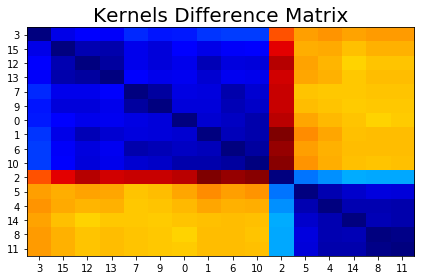

In [256]:
f, ax = plt.subplots()

ax.imshow(dmo, aspect='auto', cmap=cm.jet)

ax.set_xticks([i for i in range(len(order))])
ax.set_xticklabels(order)

ax.set_yticks([i for i in range(len(order))])
ax.set_yticklabels(order)

ax.set_title('Kernels Difference Matrix', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

Now trying to use the similarity image to buld difference matrix

In [257]:
dm = np.zeros((dh0.shape[0], dh0.shape[0]))

for k1 in range(dh0.shape[0]):
    for k2 in range(dh0.shape[0]):
        dm[k1, k2] = np.sum(np.abs(dh0[k1, :] - dh0[k2, :]))

dm.shape

(16, 16)

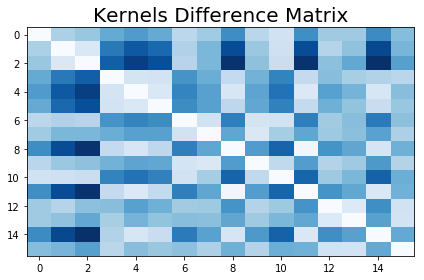

In [258]:
f, ax = plt.subplots()

ax.imshow(dm, aspect='auto', cmap=cm.Blues)

ax.set_title('Kernels Difference Matrix', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

In [259]:
# using hierarchical clustering...
clustering = AgglomerativeClustering(n_clusters=dm.shape[0], compute_full_tree=True).fit(dm)

merge_order = clustering.children_
index_list = [[i] for i in range(dm.shape[0])]

for i, j in merge_order:
    index_list.append(index_list[i] + index_list[j])

order = index_list[-1]
dmo = dm[order, :]
dmo = dmo[:, order]

/home/rafael/anaconda3/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


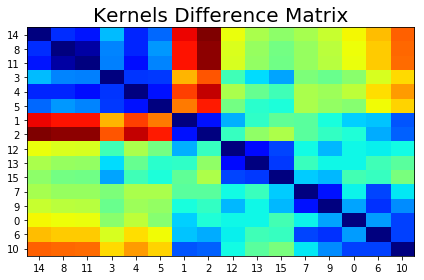

In [260]:
f, ax = plt.subplots()

ax.imshow(dmo, aspect='auto', cmap=cm.jet)

ax.set_xticks([i for i in range(len(order))])
ax.set_xticklabels(order)

ax.set_yticks([i for i in range(len(order))])
ax.set_yticklabels(order)

ax.set_title('Kernels Difference Matrix', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

# Next Steps

- Apply technique to the second layer.
- Apply technique to cifar10
- Write report

## 2nd Conv Layer

In [261]:
n_model = af.reduce_model_units(model, 0, remains2)
n_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 28, 28, 5)         50        
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 28, 28, 16)        736       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 16)                50192     
_________________________________________________________________
dense_58 (Dense)             (None, 10)                170       
Total params: 51,148
Trainable params: 51,148
Non-trainable params: 0
_________________________________________________________________


In [262]:
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 94.40%


In [263]:
h = n_model.fit(x_train, y_train, batch_size=128, epochs=1, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 31s 511us/step - loss: 0.0970 - acc: 0.9723 - val_loss: 0.0671 - val_acc: 0.9769


In [264]:
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 97.69%


First we build the Activation Matrix to check if all training elements are activating in at least a few kernels.

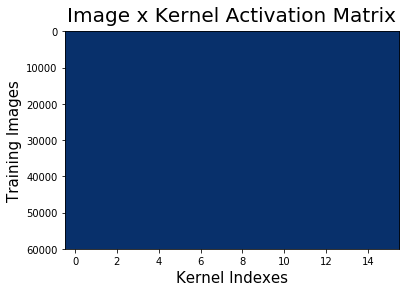

0

In [265]:
m0 = af.activation_matrix_conv2d(n_model, 1, x_train, t_labels, p_labels, num_classes)
af.plot_activation_matrix(m0)

Now we build the class histograms per position of each kernel.

In [266]:
h0, s0 = af.class_histogram_conv2d_v3(n_model, 1, x_train, t_labels, p_labels, num_classes)
h0.shape, s0.shape

((16, 28, 28, 10), (16, 28, 28, 10))

In the image below, each matrix $M_{i,j}$ corresponds to the bin sizes produced by the $i$-th neuron for the $j$-th class. Each matrix position ${k,l}$ is the bin size produced in the position/pixel ${k,l}$ of the $i$-th neuron for the $j$-th class

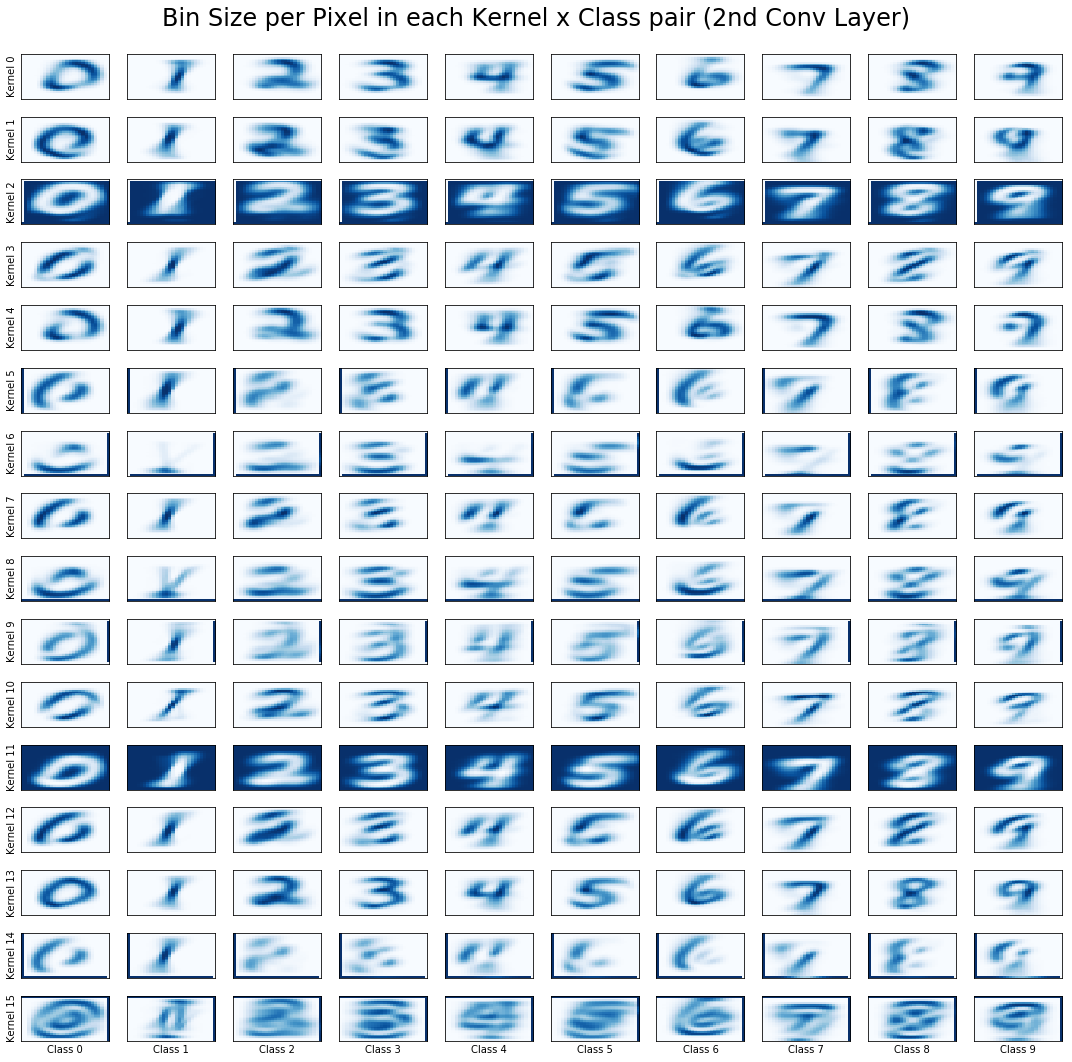

In [267]:
n_rows = h0.shape[0]
n_cols = h0.shape[3]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))

f.suptitle('Bin Size per Pixel in each Kernel x Class pair (2nd Conv Layer)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].imshow(h0[i, :, :, j], aspect='auto', cmap=cm.Blues)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(i))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel('Class ' + str(j))

f.tight_layout(rect=[0, 0, 1, 0.95])

In [268]:
h0 = af.merge_pixels_dim(h0)
s0 = af.merge_pixels_dim(s0)
h0.shape, s0.shape

((16, 784, 10), (16, 784, 10))

In [269]:
dh0 = af.position_selectivity(h0)
ds0 = af.position_selectivity(s0)

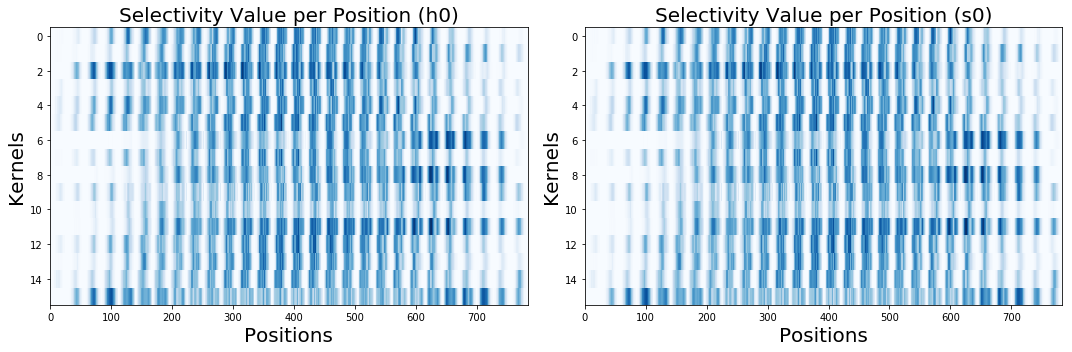

In [270]:
f, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 5))

ax0.imshow(dh0, aspect='auto', cmap=cm.Blues)
ax1.imshow(ds0, aspect='auto', cmap=cm.Blues)

ax0.set_ylabel('Kernels', fontsize=20)
ax0.set_xlabel('Positions', fontsize=20)
ax0.set_title('Selectivity Value per Position (h0)', fontsize=20)

ax1.set_ylabel('Kernels', fontsize=20)
ax1.set_xlabel('Positions', fontsize=20)
ax1.set_title('Selectivity Value per Position (s0)', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

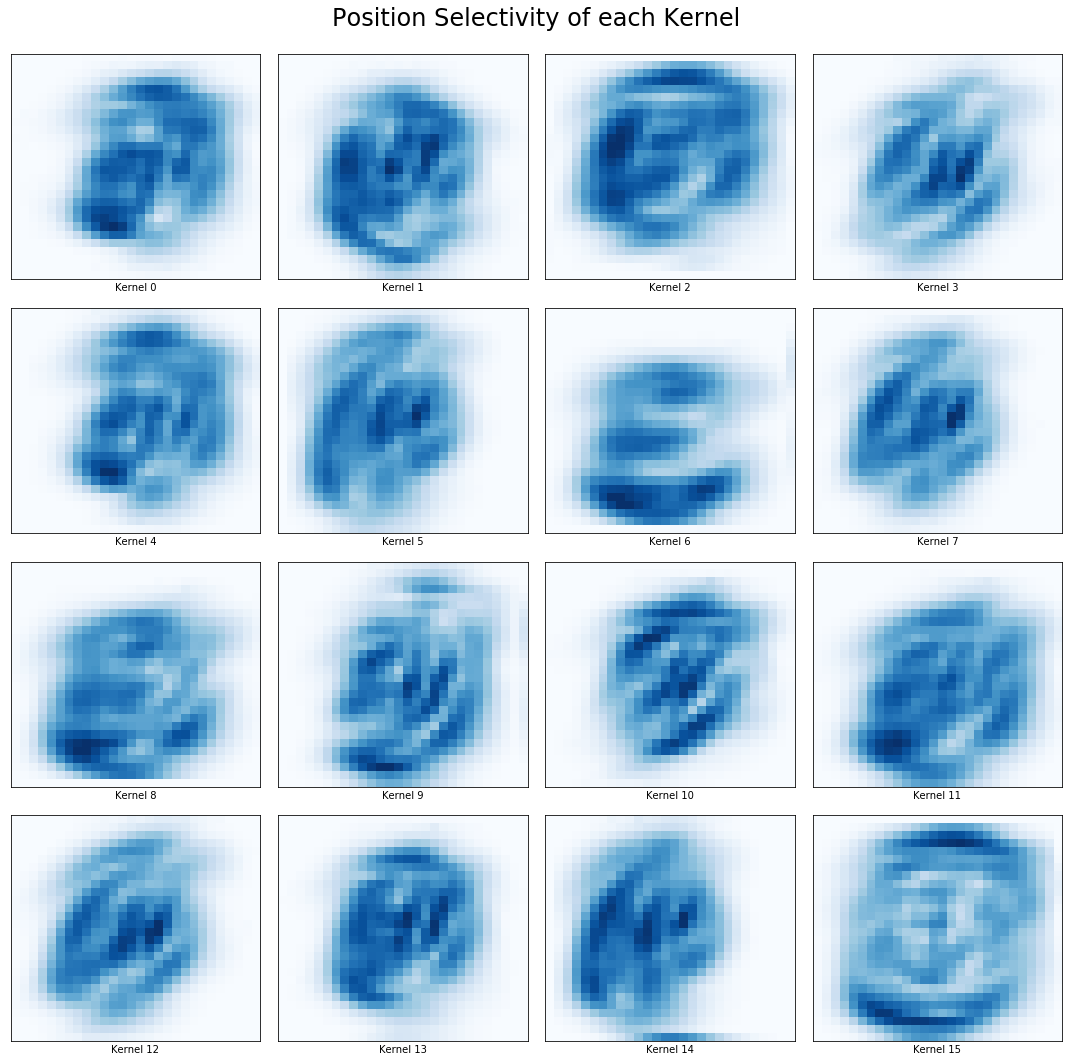

In [271]:
n_rows = int(math.sqrt(dh0.shape[0]))
n_cols = int(math.sqrt(dh0.shape[0]))

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))

f.suptitle('Position Selectivity of each Kernel', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        k = n_rows*i + j
        
        axs[i, j].imshow(dh0[k, :].reshape((28, 28)), aspect='auto', cmap=cm.Blues)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xlabel('Kernel ' + str(k))

f.tight_layout(rect=[0, 0, 1, 0.95])

In [272]:
dch0 = af.position_class_selectivity(h0)
dcs0 = af.position_class_selectivity(s0)

dch0.shape, dcs0.shape

((16, 784, 10), (16, 784, 10))

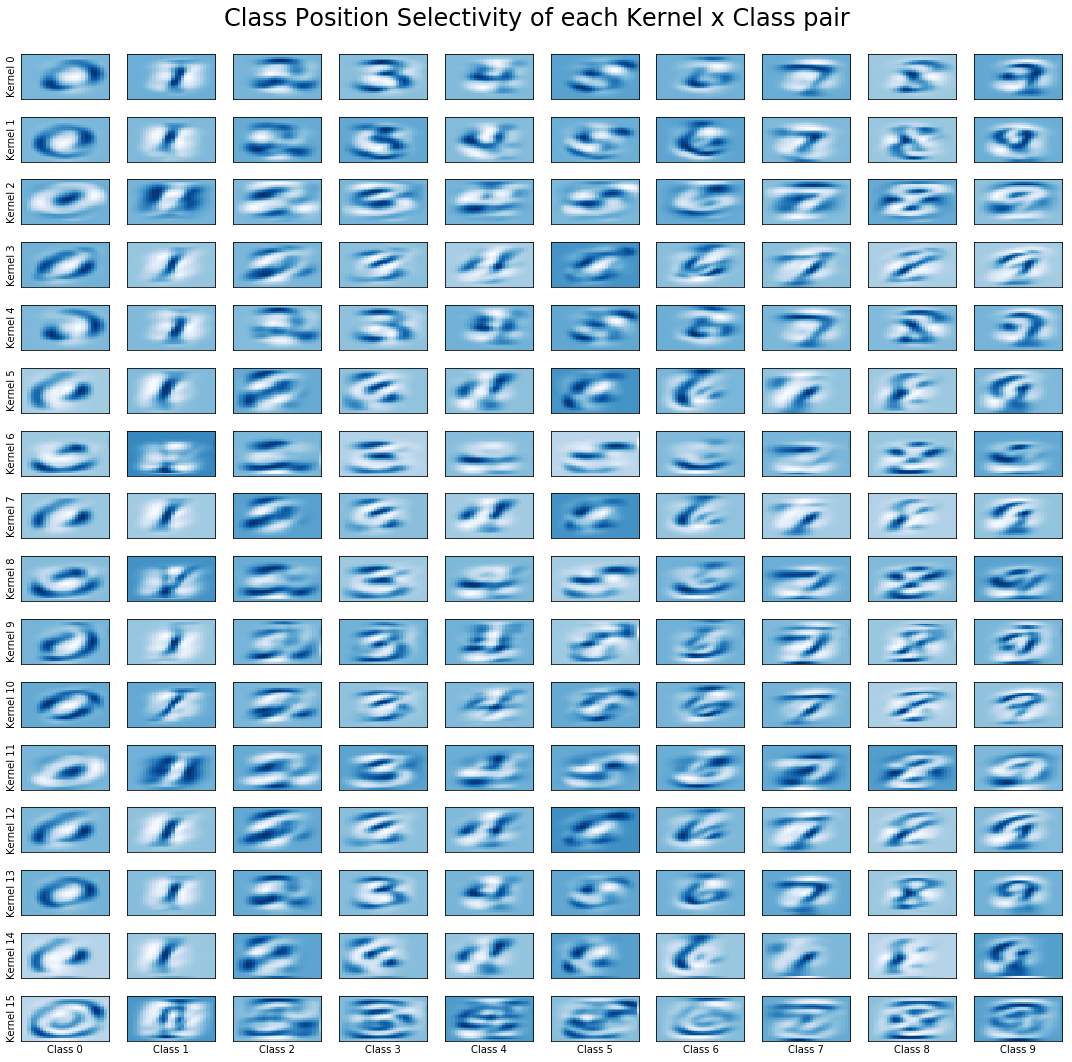

In [273]:
n_rows = dch0.shape[0]
n_cols = dch0.shape[2]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))

f.suptitle('Class Position Selectivity of each Kernel x Class pair', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].imshow(dch0[i, :, j].reshape((28, 28)), aspect='auto', cmap=cm.Blues)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(i))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel('Class ' + str(j))

f.tight_layout(rect=[0, 0, 1, 0.95])

In [274]:
dm = np.zeros((h0.shape[0], h0.shape[0]))

for k1 in range(h0.shape[0]):
    for k2 in range(h0.shape[0]):
        dm[k1, k2] = np.sum(np.abs(h0[k1, :, :] - h0[k2, :, :])) # Sum and mean bring similar results.

dm.shape

(16, 16)

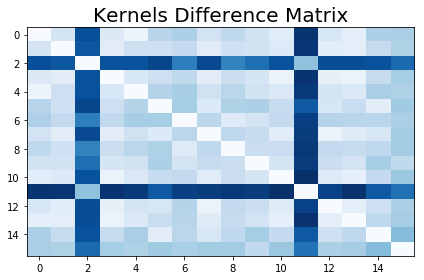

In [275]:
f, ax = plt.subplots()

ax.imshow(dm, aspect='auto', cmap=cm.Blues)

ax.set_title('Kernels Difference Matrix', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

In [276]:
# using hierarchical clustering...
clustering = AgglomerativeClustering(n_clusters=dm.shape[0], compute_full_tree=True).fit(dm)

merge_order = clustering.children_
index_list = [[i] for i in range(dm.shape[0])]

for i, j in merge_order:
    index_list.append(index_list[i] + index_list[j])

order = index_list[-1]
dmo = dm[order, :]
dmo = dmo[:, order]

/home/rafael/anaconda3/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


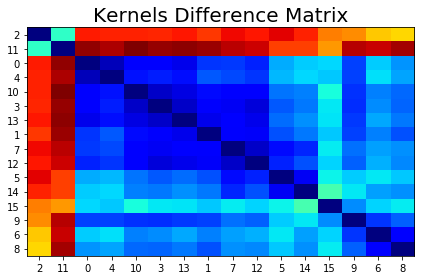

In [277]:
f, ax = plt.subplots()

ax.imshow(dmo, aspect='auto', cmap=cm.jet)

ax.set_xticks([i for i in range(len(order))])
ax.set_xticklabels(order)

ax.set_yticks([i for i in range(len(order))])
ax.set_yticklabels(order)

ax.set_title('Kernels Difference Matrix', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

Now trying to use the similarity image to buld difference matrix

In [278]:
dm = np.zeros((dh0.shape[0], dh0.shape[0]))

for k1 in range(dh0.shape[0]):
    for k2 in range(dh0.shape[0]):
        dm[k1, k2] = np.sum(np.abs(dh0[k1, :] - dh0[k2, :]))

dm.shape

(16, 16)

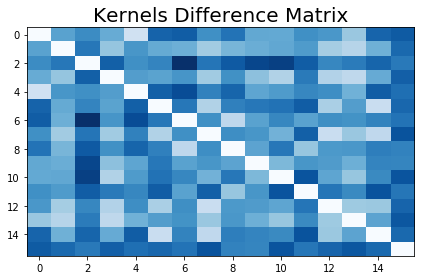

In [279]:
f, ax = plt.subplots()

ax.imshow(dm, aspect='auto', cmap=cm.Blues)

ax.set_title('Kernels Difference Matrix', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

In [280]:
# using hierarchical clustering...
clustering = AgglomerativeClustering(n_clusters=dm.shape[0], compute_full_tree=True).fit(dm)

merge_order = clustering.children_
index_list = [[i] for i in range(dm.shape[0])]

for i, j in merge_order:
    index_list.append(index_list[i] + index_list[j])

order = index_list[-1]
dmo = dm[order, :]
dmo = dmo[:, order]

/home/rafael/anaconda3/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


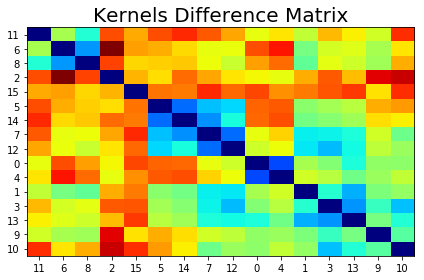

In [281]:
f, ax = plt.subplots()

ax.imshow(dmo, aspect='auto', cmap=cm.jet)

ax.set_xticks([i for i in range(len(order))])
ax.set_xticklabels(order)

ax.set_yticks([i for i in range(len(order))])
ax.set_yticklabels(order)

ax.set_title('Kernels Difference Matrix', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

In [287]:
importlib.reload(af);
ks_max = af.kernel_selectivitity(h0, dh0, 'max')
ks_mean = af.kernel_selectivitity(h0, dh0, 'mean')
ks_median = af.kernel_selectivitity(h0, dh0, 'median')
ks_pond = af.kernel_selectivitity(h0, dh0, 'pond')

ks_max.shape, ks_mean.shape, ks_median.shape

((16,), (16,), (16,))

In [298]:
np.argsort(ks_max)

array([10, 14,  9, 13,  1,  3,  7, 15,  0, 12,  4,  6,  5,  2,  8, 11])

In [299]:
# list(zip(np.argsort(ks_mean).tolist(), ks_max[np.argsort(ks_mean)].tolist(), ))
np.argsort(ks_mean)

array([10,  3,  7, 13, 14,  9,  1, 12,  0,  6,  4,  5,  8, 15, 11,  2])

In [300]:
np.argsort(ks_median)

array([10,  7, 13,  3,  0,  6,  1, 14, 12,  9,  4,  5,  8, 11,  2, 15])

In [301]:
np.argsort(ks_pond) # equal to ks_mean in this case

array([10,  3,  7, 13, 14,  9,  1, 12,  0,  6,  4,  5,  8, 15, 11,  2])

In [347]:
# Try entropy multiplied by the largest bin size.

The groups we identify in the Difference Matrix are the following:

* 11
* 6 8 (maybe join above) I vote for not doing this
* 2
* 15
* 5 14
* 7 12 (maybe join above) I vote for doing this
* 0 4
* 1
* 3 13 (maybe join above) Let's try later
* 10   (maybe join above) I vote for not doing this
* 9	 (1st DM says to join with 6, 8) Definitely not doing this!

In [302]:
remains0 = np.array([1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 15])
remains1 = np.array([1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 15])
remains2 = np.array([1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 15]) # equal max

In [303]:
n_model2 = af.reduce_model_units(n_model, 1, remains0)
scores = n_model2.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 96.65%


In [304]:
n_model2 = af.reduce_model_units(n_model, 1, remains1)
scores = n_model2.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 97.02%


In [306]:
n_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 28, 28, 5)         50        
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 28, 28, 11)        506       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 14, 14, 11)        0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 2156)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 16)                34512     
_________________________________________________________________
dense_62 (Dense)             (None, 10)                170       
Total params: 35,238
Trainable params: 35,238
Non-trainable params: 0
_________________________________________________________________


In [307]:
avg_score = 0.0
t = 20

for _ in range(t):
    remains = np.array(random.sample(range(16), 11))
    n_model2 = af.reduce_model_units(n_model, 1, remains)
    
    scores = n_model2.evaluate(x_test, y_test, verbose=2)
    avg_score += scores[1]*100 / t
    
print("Average Accuracy with Random Dropping: %.2f%%" % avg_score)

Average Accuracy with Random Dropping: 92.41%


Now lets remove more kernels based on selectivity.

In [342]:
# array([10, 14,  9, 13,  1,  3,  7, 15,  0, 12,  4,  6,  5,  2,  8, 11])
remains0 = np.array([2, 3, 4, 5, 8, 11, 12, 15])

# array([10,  3,  7, 13, 14,  9,  1, 12,  0,  6,  4,  5,  8, 15, 11,  2])
remains1 = np.array([1, 2, 4, 5, 8, 11, 12, 15])

# array([10,  7, 13,  3,  0,  6,  1, 14, 12,  9,  4,  5,  8, 11,  2, 15])
remains2 = np.array([2, 4, 5, 8, 9, 11, 12, 15]) # equal max

In [343]:
n_model2 = af.reduce_model_units(n_model, 1, remains0)
scores = n_model2.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 96.82%


In [344]:
n_model2 = af.reduce_model_units(n_model, 1, remains1)
scores = n_model2.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 96.81%


In [345]:
n_model2 = af.reduce_model_units(n_model, 1, remains2)
scores = n_model2.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 96.67%


In [346]:
avg_score = 0.0
t = 20

for _ in range(t):
    remains = np.array(random.sample(range(16), 8))
    n_model2 = af.reduce_model_units(n_model, 1, remains)
    
    scores = n_model2.evaluate(x_test, y_test, verbose=2)
    avg_score += scores[1]*100 / t
    
print("Average Accuracy with Random Dropping: %.2f%%" % avg_score)

Average Accuracy with Random Dropping: 79.52%
